# Abdul Haseeb - 17132
# Farjad Ahmed Siddiqui – 29405
# Machine Learning - I (75767/40243)
# Assignment # 1

# Datasets
## Dataset - 1
### Title: Adult Income
### URL: https://archive.ics.uci.edu/dataset/2/adult
### UCI ID: 2
### Domain: Social Science
### Feature Type: Mixed
### No. of Features: 14
### No. of Rows: 48842
# 
## Dataset - 2
### Title: Credit Approval
### URL: https://archive.ics.uci.edu/dataset/27/credit+approval
### UCI ID: 27
### Domain: Business
### Feature Type: Mixed
### No. of Features: 15
### No. of Rows:690
# 
## Dataset - 3
### Title: Mushroom Classification
### URL: https://archive.ics.uci.edu/dataset/73/mushroom
### UCI ID: 73
### Domain: Biology
### Feature Type: Categorical
### No. of Features: 22
### No. of Rows:8124
# 
## Dataset - 4
### Title: Bank Marketing
### URL: https://archive.ics.uci.edu/dataset/222/bank+marketing
### UCI ID: 222
### Domain: Business
### Feature Type: Mixed
### No. of Features: 16
### No. of Rows: 45211
# 
## Dataset - 5
### Title: Heart Disease
### URL: https://archive.ics.uci.edu/dataset/45/heart+disease
### UCI ID: 45
### Domain: Health & Medicine
### Feature Type: Mixed
### No. of Features: 13
### No. of Rows: 303

In [1]:
# Importing Dependencies
import pandas as pd
import numpy as np
#pip install ucimlrepo in anaconda command line prompt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from scipy.stats import skew, kurtosis, jarque_bera
import seaborn as sns
import matplotlib.pyplot as plt
#pip install lazypredict in anaconda command line prompt
from lazypredict.Supervised import LazyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve

In [2]:
# Support Function

# Data Fetching Function
def get_data(id):
    data=fetch_ucirepo(id=id)
    X = data.data.features 
    y = data.data.targets
    df= pd.merge(X, y, left_index=True, right_index=True)
    return df, y.columns[0]

# Missing Values Treatment
def missing_value_treatment(df):
    missing_columns=(df.isna().sum()!=0)[(df.isna().sum()!=0)].index
    for i in missing_columns:
        if ((df[i].isna().sum()/len(df))<=0.05) & len(df)>30000:
            df[i].dropna(inplace=True)
            df.reset_index(inplace=True,drop=True)
        elif (df[i].isna().sum()/len(df))>0.5:
            df.drop([i],axis=1,inplace=True)
        elif (df[i].dtype=='object') or (df[i].dtype.name=='category'):
            mode_val = df[i].mode()[0]
            df[i].fillna(mode_val, inplace=True)
        else:
            skewness=skew(df[i].dropna())
            if abs(skewness)>1:
                df[i].fillna(df[i].median(), inplace=True)
            else:
                df[i].fillna(df[i].mean(), inplace=True)
    print("Dataset is treated for missing values successfully")

# Standardization of Numerical Columns
def data_standardization(df,type):
    num_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype!='object') and (df[i].dtype.name!='category'):
            num_var.append(i)
    if type==1:
        scaler=StandardScaler()
        for i in num_var:
            df[i]=scaler.fit_transform(df[[i]]).round(2)
    elif type==2:
        scaler = MinMaxScaler()
        for i in num_var:
            df[i]=scaler.fit_transform(df[[i]]).round(2)

# Categorical Encoding
def cat_encoding(df):
    cat_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype=='object') or (df[i].dtype.name=='category'):
            cat_var.append(i)
    label_encoder = LabelEncoder()
    for feature in cat_var:
        df[feature] = label_encoder.fit_transform(df[feature])

# Numerical Summary
def num_summary(df):
    return df.describe()

# Class Balance
def class_balance(df):
    return (df[label_column].value_counts(normalize=True)*100)

# Pick top 5 important numerical features
def top_5_num_features(df):
    num_var=[]
    for i in df.drop([label_column],axis=1).columns:
        if (df[i].dtype!='object') and (df[i].dtype.name!='category'):
            num_var.append(i)
    X_train=df[num_var]
    y_train=df[label_column]
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)
    feature_importances = rf_classifier.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    top_5_numerical_features = feature_importance_df.head(5)['Feature'].tolist()
    return top_5_numerical_features

# Construct histogram and boxplot of important numerical features
def hist_box_plots(df):
    num_features=top_5_num_features(df)
    for i in num_features:
        print("")
        print(f"Box and Distribution Plot - {i}")
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df[i])
        plt.title('Box Plot')
        plt.show()

        plt.figure(figsize=(8, 4))
        sns.histplot(data=df[i])
        plt.title('Distribution Plot')
        plt.show()

        skewness=skew(df[i])
        kurt=kurtosis(df[i])
        JB,p_val=jarque_bera(df[i])
    
        print("Skewness:",skewness)
        if skewness<0:
            print("Left Skewed",'\n')
        elif skewness>0:
            print("Right Skewed",'\n')
        else:
            print("Center",'\n')

        print("Kurtosis:",kurt)
        if kurt<3:
            print("Platykurtic",'\n')
        elif kurt>3:
            print("Leptokurtic",'\n')
        else:
            print("Mesokurtic",'\n')
    
        print("JB Test for Normality")
        print(JB,p_val)
        if p_val<0.05:
            print("Distribution is not normal",'\n')
        else:
            print("Distribution is normal",'\n')

# Data Split and CV
def data_split_and_CV(df):
    seed=int(input("Random State? "))
    test_size=int(input("What % of data to be left for test? "))/100
    k=int(input("How many folds required? "))
    X=df.drop([label_column],axis=1)
    y=df[label_column]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=seed)
    
    sk_folds=StratifiedKFold(n_splits=k,random_state=seed,shuffle=True)
    
    return X_train,X_test,y_train,y_test,sk_folds

# Model Selection
def models(X_train, X_test, y_train, y_test):
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train, X_test, y_train, y_test)
    print(models)
    
# Model Training
def knn_learn(df,X_train,y_train,X_test,sk_folds):
    k=int(input("What is the value of K? "))
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scoresCV=cross_val_score(knn, df.drop([label_column],axis=1), df[label_column], cv = sk_folds)
    return knn, scoresCV

# Model Evaluation
def model_eval(knn,X_test,y_test,scoresCV):
    y_prob=knn.predict_proba(X_test)
    y_pred_test=knn.predict(X_test)
    auc=roc_auc_score(y_test, y_prob[:, 1])
    class_report=classification_report(y_test, y_pred_test, output_dict=True,target_names=df[label_column].unique().tolist())
    df_report = pd.DataFrame(class_report).transpose()
    
    print("")
    print("")
    print("")
    print ("Train-Test Split Evaluation")
    print(df_report)
    
    plot_roc_curve(knn, X_test, y_test)
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    print("")
    print("")
    print("")
    print("Cross-Validation Evaluation")
    print("Cross Validation Scores: ", scoresCV)
    print("Average CV Score: ", scoresCV.mean())
    print("Number of CV Scores used in Average: ", len(scoresCV))

In [3]:
# Master Function
def master(data=None,X_train=None, X_test=None, y_train=None, y_test=None,sk_folds=None,knn=None,scoresCV=None):
    print("1- Fetch Data","2- Missing Values Treatment","3- EDA: Numerical Summary",
          "4- EDA: Class Balance(%)","5- EDA: Histogram & Box Plot of Important Numerical Features",
          "6- Categorical Encoding","7- Standardization of Numerical Features",
          "8- Outliers Detection & Treatment","9-  Data Splitting & Cross-Validation",
          "10- Model Selection","11- Model Training(KNN)", "12- Model Evaluation",
          "13- More Functions to be Added",sep='\n')
    sr=int(input("What do you want to do? "))
    
    if sr==1 and data==None:
        id=int(input("Please enter the UCI ID "))
        df=get_data(id)
        print("Successfuly Connected to the Data Source")
        return df
    
    elif sr==2:
        missing_value_treatment(data)
    
    elif sr==7:
        print("1- Standard Scaler","2- Min-Max Scaler", sep='\n')
        type=int(input("Which type of Scaler? "))
        data_standardization(data,type)
    
    elif sr==6:
        cat_encoding(data)
    
    elif sr==3:
        return num_summary(data)
    
    elif sr==4:
        return class_balance(data)
    
    elif sr==5:
        hist_box_plots(data)
    
    elif sr==8:
        return "Outlier detection and treatment functionality under progress!"
    
    elif sr==9:
        return data_split_and_CV(data)
    
    elif sr==10:
        models(X_train, X_test, y_train, y_test)
    
    elif sr==11:
        return knn_learn(data,X_train,y_train,X_test,sk_folds)
    
    elif sr==12:
        model_eval(knn,X_test,y_test,scoresCV)
    
    else:
        return "Please either select correct option or wait for future updates!"

## Dataset - 1
### Title: Adult Income

#### Data Connection

In [4]:
# Dataset Fetching (Pipeline Function)
df,label_column=master()

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 1
Please enter the UCI ID 2
Successfuly Connected to the Data Source


In [5]:
# The snapshot below shows that the data contains data entry errors where some missing values are written as '?'
df.head(20)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


#### Data Cleaning

In [6]:
# No Manual Data Type Correction Required
print(df.dtypes,'\n')

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object 



In [7]:
# Manual Data Entry Error Correction
print(df.isin(["?"]).sum()!=0)
question_mark_columns=(df.isin(["?"]).sum()!=0)[(df.isin(["?"]).sum()!=0)].index
for i in question_mark_columns:
    df[i]=df[i].replace(to_replace='?',value=np.NaN)

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
income            False
dtype: bool


In [8]:
# Manual data label cleaning
print(df[label_column].unique())
df[label_column] = df[label_column].replace({'<=50K.': '<=50K', '>50K.': '>50K'})

['<=50K' '>50K' '<=50K.' '>50K.']


In [9]:
# Missing Value Treatment (Pipeline Function)
master(df)
print(" ")
print(df.isna().sum())

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 2
Dataset is treated for missing values successfully
 
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [10]:
# Manually removing redundant columns
# fnlwgt appears to be some sort of sampling weight (number of people in population representated by a particular sample or record) which is irrelevant to when analyzing a subset of large dataset and for the purpose of EDA
df=df.drop(columns='fnlwgt')

In [11]:
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Exploratory Data Analysis

In [12]:
# Numerical Features Summary (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 3


,age,education-num,capital-gain,capital-loss,hours-per-week
count,48842.00,48842.00,48842.00,48842.00,48842.00
mean,38.64,10.08,1079.07,87.50,40.42
std,13.71,2.57,7452.02,403.00,12.39
min,17.00,1.00,0.00,0.00,1.00
25%,28.00,9.00,0.00,0.00,40.00
50%,37.00,10.00,0.00,0.00,40.00
75%,48.00,12.00,0.00,0.00,45.00
max,90.00,16.00,99999.00,4356.00,99.00


In [13]:
# Target Feature Class Balance (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 4


<=50K   76.07
>50K    23.93
Name: income, dtype: float64

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 5

Box and Distribution Plot - age


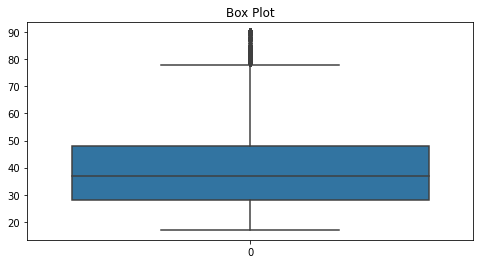

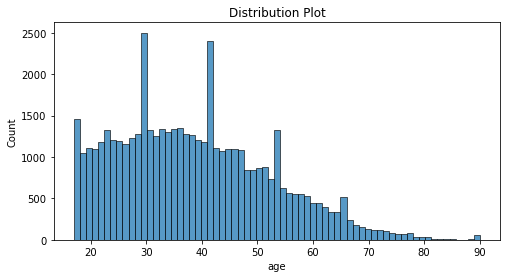

Skewness: 0.5575631924658626
Right Skewed 

Kurtosis: -0.18437271998309956
Platykurtic 

JB Test for Normality
2599.8192722344866 0.0
Distribution is not normal 


Box and Distribution Plot - capital-gain


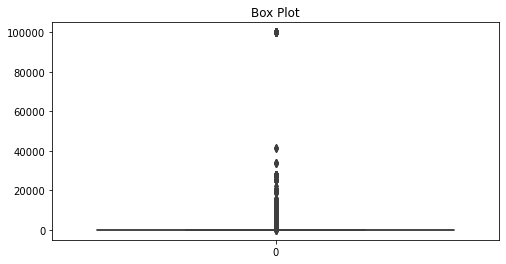

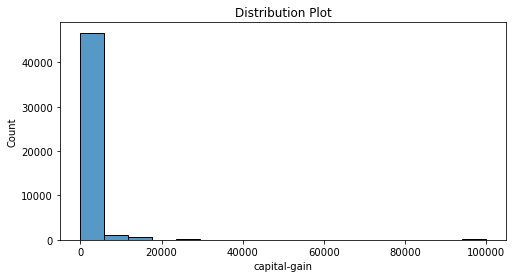

Skewness: 11.894293693350868
Right Skewed 

Kurtosis: 152.6773425724958
Leptokurtic 

JB Test for Normality
48590194.712563224 0.0
Distribution is not normal 


Box and Distribution Plot - education-num


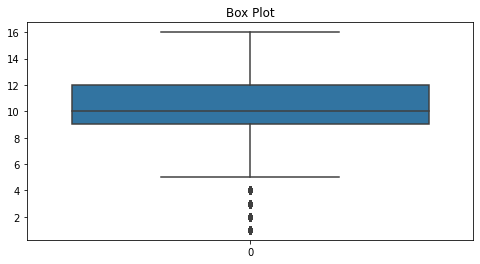

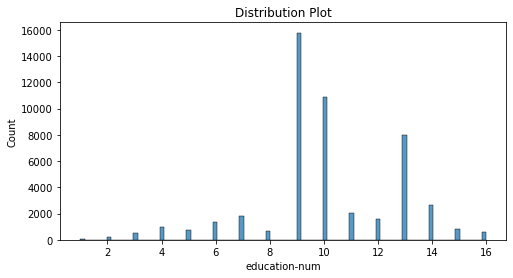

Skewness: -0.3165151356965018
Left Skewed 

Kurtosis: 0.6255583739336319
Platykurtic 

JB Test for Normality
1611.8889827431972 0.0
Distribution is not normal 


Box and Distribution Plot - hours-per-week


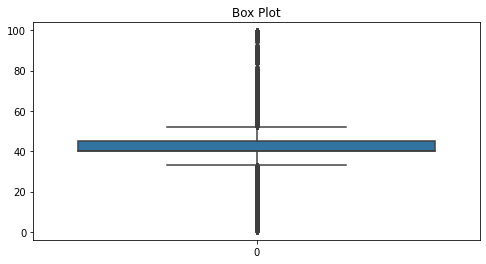

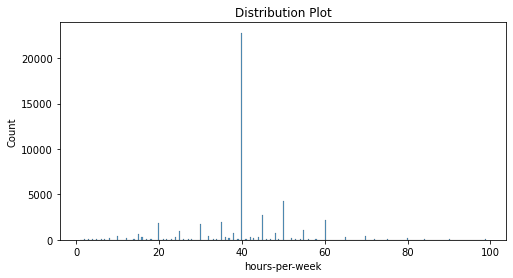

Skewness: 0.2387423248342843
Right Skewed 

Kurtosis: 2.950634153321035
Platykurtic 

JB Test for Normality
18181.909686694897 0.0
Distribution is not normal 


Box and Distribution Plot - capital-loss


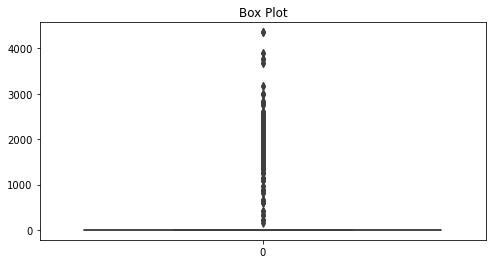

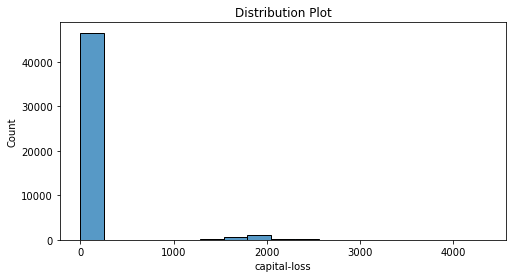

Skewness: 4.569668511893423
Right Skewed 

Kurtosis: 20.012174283988244
Leptokurtic 

JB Test for Normality
985010.0471924777 0.0
Distribution is not normal 



In [14]:
# Histograms and Boxplots of important numerical variables (Pipeline Function)
master(df)

## EDA Interpretation

## 1. Age 

####   Based on the interpretation of the box plot, it is observed that the interquartile range (IQR), representing the middle 50% of the data, spans from approximately 28 to 48. Additionally, the median line, which denotes the central tendency of the data, is positioned closer to the lower end of the box. These observations indicate a positive skewness in the distribution. Positive skewness implies that the tail of the distribution extends towards higher values, with a greater concentration of data points towards the lower end.

#### The data distribution is right-skewed, indicating that it is asymmetric with a longer tail on the right side.
#### The distribution has lighter tails and is less peaked than a normal distribution, suggesting fewer extreme values.
#### The data does not follow a normal distribution, as indicated by both statistical tests and visual inspection of the histogram and box plot. This implies that the assumptions of normality may not hold for this dataset, and further analysis or modeling should take this into account.
    
## 2. education num (the number of years of education)

####  Based on the box plot analysis, it is observed that 50% of the dataset falls within the range of 9 to 12, with the median line positioned slightly closer to the lower quartile, indicative of a mild positive skew. This observed skewness contrasts with the left-skewed impression conveyed by the histogram. This discrepancy is attributed to the presence of outliers predominantly concentrated at the lower end of the data distribution.

#### The data distribution is left-skewed, with a higher concentration of data towards higher values and a tail extending towards lower values.
#### The distribution is platykurtic, indicating a lower likelihood of extreme values and a flatter peak compared to a normal distribution.
#### The data does not follow a normal distribution, as indicated by both the skewness, kurtosis, and the Jarque-Bera test. This suggests that assumptions of normality are violated, and caution should be exercised in subsequent analyses or modeling

## 3. Hours (worked) per week: Discrete (from 1 to 99)

####  The box plot analysis reveals that 50% of the data observations are situated within the interquartile range, spanning from approximately 40 to 45. Additionally, the median line, denoting the central tendency, is positioned towards the upper portion of the box. These observations indicate a negatively skewed distribution, where the tail extends towards lower values while the bulk of the data is concentrated towards higher values. However, it is pertinent to note the presence of abnormally high outliers at the upper end, which contribute to a divergence from the expected distributional pattern.

#### The data distribution is right-skewed, with a higher concentration of data towards lower values and a tail extending towards higher values.
#### The distribution is platykurtic, indicating a lower likelihood of extreme values and a flatter peak compared to a normal distribution.
#### The data does not follow a normal distribution, as indicated by both the skewness, kurtosis, and the Jarque-Bera test. This suggests that assumptions of normality are violated, and caution should be exercised in subsequent analyses or modeling


## 4. Capital Gain:

####   The interpretation of the box plot reveals that 50% of the data values fall within the range of 0 to 0, as indicated by the interquartile range (IQR). Additionally, the median line, representing the central tendency, is situated towards the lower portion of the box. These observations suggest a positive skewness in the distribution, signifying that the tail of the distribution extends towards higher values while the bulk of the data is concentrated towards lower values. However, it is noteworthy that the box plot exhibits extreme outliers, indicating the presence of values significantly deviating from the overall trend of the data

#### The data distribution is heavily right-skewed, indicating that it is highly asymmetric with a very long tail on the right side.
#### The distribution has very heavy tails and a very sharp peak, suggesting many extreme values and a high concentration of values around the mean.
#### The data does not follow a normal distribution, as indicated by both statistical tests and visual inspection of the histogram and box plot. This implies that the assumptions of normality do not hold for this dataset, and further analysis or modeling should take this into account.

## 5. Capital Loss:

####   The analysis of the box plot reveals that the interquartile range (IQR), representing the middle 50% of the data, spans from 0 to 0. Furthermore, the median line, which represents the central tendency of the data, is positioned towards the lower portion of the box. These observations collectively suggest a positive skewness in the distribution, indicating that the tail of the distribution extends towards higher values while the bulk of the data is concentrated towards lower values.

#### Heavy right-skewness, with a long tail towards higher values.
#### Leptokurtosis, indicating heavy tails and a sharp peak.
#### Significant deviation from normality, as evidenced by both the high skewness and kurtosis values, as well as the Jarque-Bera test result.

#### Data Transformation

In [15]:
# Categorical Encoding (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 6


In [16]:
# Standardization of Numerical Features (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 7
1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


In [17]:
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.03,2.61,-0.33,1.14,0.92,-1.55,-0.28,0.39,0.70,0.15,-0.22,-0.03,0.26,<=50K
1,0.83,1.71,-0.33,1.14,-0.41,-0.79,-0.90,0.39,0.70,-0.14,-0.22,-2.21,0.26,<=50K
2,-0.05,-0.09,0.18,-0.42,-1.74,-0.29,-0.28,0.39,0.70,-0.14,-0.22,-0.03,0.26,<=50K
3,1.05,-0.09,-2.40,-1.20,-0.41,-0.29,-0.90,-1.97,0.70,-0.14,-0.22,-0.03,0.26,<=50K
4,-0.78,-0.09,-0.33,1.14,-0.41,0.72,2.22,-1.97,-1.42,-0.14,-0.22,-0.03,-5.38,<=50K


#### Outlier Detection & Treatment

In [18]:
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 8


'Outlier detection and treatment functionality under progress!'

#### Feature Selection & Dimensionality Reduction not to be done in this submission as per the instructions

#### Data Splitting and Cross-Validation

In [19]:
# Train-Test Split and CV Folds (Pipeline Function)
X_train,X_test,y_train,y_test,sk_folds=master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 9
Random State? 42
What % of data to be left for test? 20
How many folds required? 5


#### Model Selection

In [20]:
# Model Selection (Pipeline Function)
#master(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
# Output not shown in compiled notebook due to limited RAM
# Cell below shows the relevant excerpt from the output when one dataset per notebook is executed separately.

In [21]:
# For this submission, our model of choice is KNN:

# Model                            Accuracy  Balanced Accuracy  ROC AUC  F1 Score                                                                       
# KNeighborsClassifier               0.83               0.74     None      0.82 

#### Model Training

In [22]:
# Model Training (Pipeline Function)
knn,scoresCV=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train,sk_folds=sk_folds)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 11
What is the value of K? 3


#### Model Evaluation

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 12



Train-Test Split Evaluation
              precision  recall  f1-score  support
<=50K              0.87    0.90      0.89  7414.00
>50K               0.65    0.58      0.61  2355.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.76    0.74      0.75  9769.00
weighted avg       0.82    0.82      0.82  9769.00


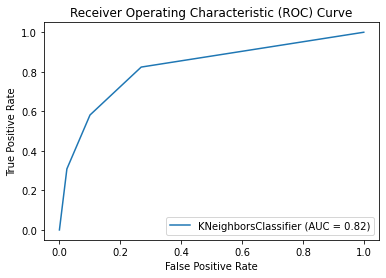




Cross-Validation Evaluation
Cross Validation Scores:  [0.8232163  0.82516122 0.82585995 0.83200246 0.8272932 ]
Average CV Score:  0.8267066261768893
Number of CV Scores used in Average:  5


In [24]:
# Model Evaluation (Pipeline Function)
master(knn=knn,X_test=X_test,y_test=y_test,scoresCV=scoresCV)

## ML Result Interpretation

### Classes: >50k , <=50k
## Train-Test Split Evaluation:
#### For the class '<=50K', the precision is 0.87, indicating that 87% of the instances classified as '<=50K' are actually in the '<=50K' income category.
#### For the class '>50K', the precision is 0.65, indicating that 65% of the instances classified as '>50K' are actually in the '>50K' income category.
#### For the class '<=50K', the recall is 0.90, indicating that 90% of the actual '<=50K' instances were correctly identified by the classifier.
#### For the class '>50K', the recall is 0.58, indicating that 58% of the actual '>50K' instances were correctly identified by the classifier.
#### For the class '<=50K', the F1-score is 0.89, representing the overall performance in terms of both precision and recall.
#### For the class '>50K', the F1-score is 0.61, also representing the overall performance in terms of both precision and recall.
#### Accuracy measures the overall correctness of the classifier across all classes. The overall accuracy of the classifier is 0.82, or 82%.

#### AUC (Area Under the ROC Curve): The AUC score of 0.82 represents the model's ability to discriminate between positive and negative instances, with a higher value indicating better discrimination capability.

## Cross-Validation Evaluation:

#### Cross-Validation Scores: The cross-validation scores, ranging from 0.8232 to 0.8320, represent the accuracy achieved by the model across different folds of the dataset during cross-validation.
#### Average CV Score: The average cross-validation score, calculated as 0.8267, provides an overall estimate of the model's performance across all folds. This score indicates the generalization ability of the model.
#### Number of CV Scores used in Average: The average cross-validation score is based on 5 cross-validation scores, ensuring a robust estimate of the model's performance.


#### In summary, both evaluations indicate that the model demonstrates favorable performance in terms of precision, recall, F1 score, accuracy, and AUC. The consistency of performance across cross-validation folds further validates the model's effectiveness and generalization ability.

#### The Cross-Validation Evaluation shows slightly better results in terms of generalization performance. This suggests that the model's performance, as assessed through cross-validation, is slightly more reliable and indicative of its ability to generalize to unseen data compared to the single train-test split evaluation.

## Dataset - 2
### Title: Credit Approval

#### Data Connection

In [25]:
# Dataset Fetching (Pipeline Function)
df,label_column=master()

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 1
Please enter the UCI ID 27
Successfuly Connected to the Data Source


In [26]:
# Missing Values are Present
df.tail(20)

,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1,A16
670,150,465.00,g,f,0,f,f,5.50,v,w,g,u,5.83,47.17,b,-
671,2,0.00,g,f,0,f,f,0.50,v,cc,g,u,12.84,25.83,b,-
672,117,240.00,g,t,0,f,f,0.50,v,aa,g,u,0.83,50.25,a,-
673,17,256.00,g,f,0,f,f,2.00,h,e,p,y,2.00,29.50,NaN,-
674,246,260.00,g,f,0,f,f,0.21,h,i,g,u,2.50,37.33,a,-
675,237,240.00,g,f,0,f,f,0.67,v,aa,g,u,1.04,41.58,a,-
676,3,129.00,g,t,12,t,f,0.09,h,q,g,u,10.66,30.58,a,-
677,1,100.00,g,f,1,t,f,0.04,v,m,g,u,7.25,19.42,b,-
678,50,0.00,g,f,0,f,f,0.00,ff,ff,g,u,10.21,17.92,a,-
679,0,0.00,g,f,0,f,f,0.00,v,c,g,u,1.25,20.08,a,-


#### Data Cleaning

In [27]:
# Manual Checking
# No Manual Data Type Correction and Removal of Redundant Column Required 
print(df.info())

# No Manual label Correction Required
print("")
print(df[label_column].value_counts())

# No Manual Data Entry Error Correction Required
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A15     690 non-null    int64  
 1   A14     677 non-null    float64
 2   A13     690 non-null    object 
 3   A12     690 non-null    object 
 4   A11     690 non-null    int64  
 5   A10     690 non-null    object 
 6   A9      690 non-null    object 
 7   A8      690 non-null    float64
 8   A7      681 non-null    object 
 9   A6      681 non-null    object 
 10  A5      684 non-null    object 
 11  A4      684 non-null    object 
 12  A3      690 non-null    float64
 13  A2      678 non-null    float64
 14  A1      678 non-null    object 
 15  A16     690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB
None

-    383
+    307
Name: A16, dtype: int64


,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1,A16
0,0,202.00,g,f,1,t,t,1.25,v,w,g,u,0.00,30.83,b,+
1,560,43.00,g,f,6,t,t,3.04,h,q,g,u,4.46,58.67,a,+
2,824,280.00,g,f,0,f,t,1.50,h,q,g,u,0.50,24.50,a,+
3,3,100.00,g,t,5,t,t,3.75,v,w,g,u,1.54,27.83,b,+
4,0,120.00,s,f,0,f,t,1.71,v,w,g,u,5.62,20.17,b,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0,260.00,g,f,0,f,f,1.25,h,e,p,y,10.09,21.08,b,-
686,394,200.00,g,t,2,t,f,2.00,v,c,g,u,0.75,22.67,a,-
687,1,200.00,g,t,1,t,f,2.00,ff,ff,p,y,13.50,25.25,a,-
688,750,280.00,g,f,0,f,f,0.04,v,aa,g,u,0.20,17.92,b,-


In [28]:
# Missing Value Treatment (Pipeline Function)
master(df)
print(" ")
print(df.isna().sum())

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 2
Dataset is treated for missing values successfully
 
A15    0
A14    0
A13    0
A12    0
A11    0
A10    0
A9     0
A8     0
A7     0
A6     0
A5     0
A4     0
A3     0
A2     0
A1     0
A16    0
dtype: int64


In [29]:
df.head()

,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1,A16
0,0,202.00,g,f,1,t,t,1.25,v,w,g,u,0.00,30.83,b,+
1,560,43.00,g,f,6,t,t,3.04,h,q,g,u,4.46,58.67,a,+
2,824,280.00,g,f,0,f,t,1.50,h,q,g,u,0.50,24.50,a,+
3,3,100.00,g,t,5,t,t,3.75,v,w,g,u,1.54,27.83,b,+
4,0,120.00,s,f,0,f,t,1.71,v,w,g,u,5.62,20.17,b,+


#### Exploratory Data Analysis

In [30]:
# Numerical Features Summary (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 3


,A15,A14,A11,A8,A3,A2
count,690.00,690.00,690.00,690.00,690.00,690.00
mean,1017.39,183.56,2.40,2.22,4.76,31.51
std,5210.10,172.19,4.86,3.35,4.98,11.86
min,0.00,0.00,0.00,0.00,0.00,13.75
25%,0.00,80.00,0.00,0.17,1.00,22.67
50%,5.00,160.00,0.00,1.00,2.75,28.46
75%,395.50,272.00,3.00,2.62,7.21,37.71
max,100000.00,2000.00,67.00,28.50,28.00,80.25


In [31]:
# Target Feature Class Balance (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 4


-   55.51
+   44.49
Name: A16, dtype: float64

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 5

Box and Distribution Plot - A8


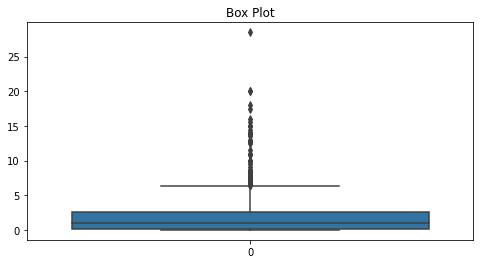

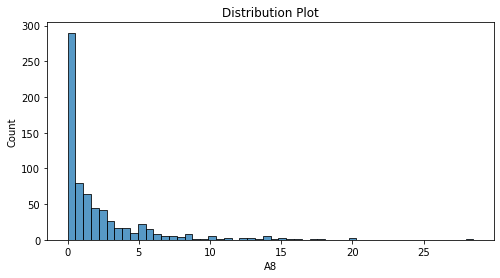

Skewness: 2.885041123784296
Right Skewed 

Kurtosis: 11.110512282615252
Leptokurtic 

JB Test for Normality
4506.198304368205 0.0
Distribution is not normal 


Box and Distribution Plot - A11


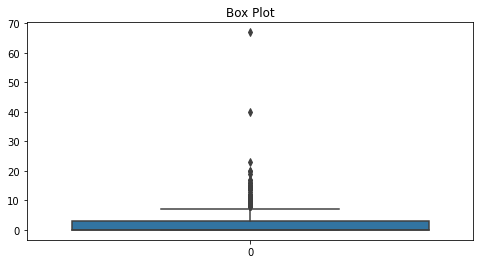

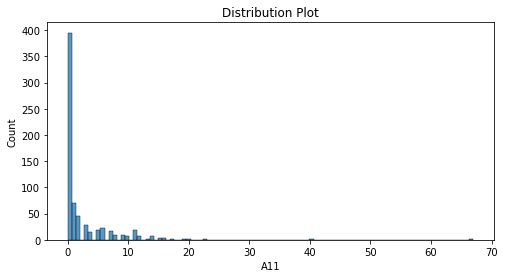

Skewness: 5.141311956483638
Right Skewed 

Kurtosis: 50.453165554366365
Leptokurtic 

JB Test for Normality
76223.56023351505 0.0
Distribution is not normal 


Box and Distribution Plot - A15


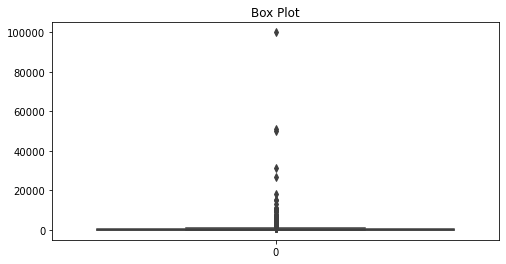

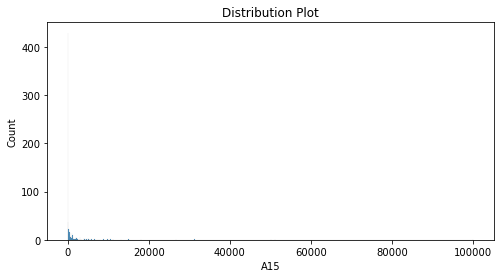

Skewness: 13.112071105201627
Right Skewed 

Kurtosis: 213.10886283673105
Leptokurtic 

JB Test for Normality
1325463.9253092878 0.0
Distribution is not normal 


Box and Distribution Plot - A3


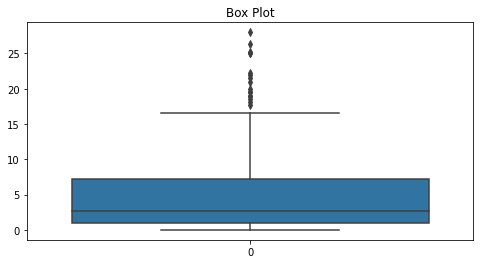

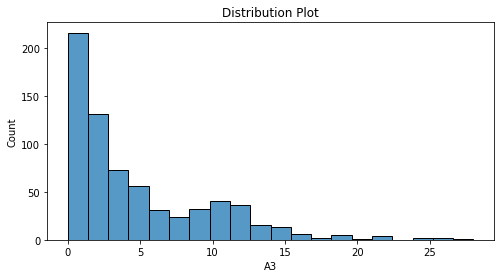

Skewness: 1.4855746179702647
Right Skewed 

Kurtosis: 2.2488937993362494
Platykurtic 

JB Test for Normality
399.20096920903694 0.0
Distribution is not normal 


Box and Distribution Plot - A2


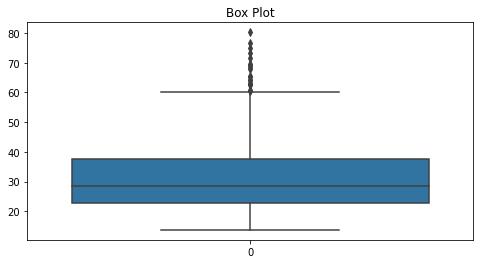

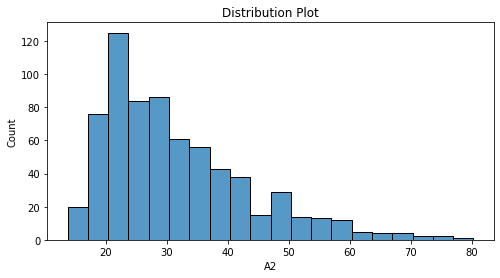

Skewness: 1.1647650704131591
Right Skewed 

Kurtosis: 1.1861668575026014
Platykurtic 

JB Test for Normality
196.4689466121067 0.0
Distribution is not normal 



In [32]:
# Histograms and Boxplots of important numerical variables (Pipeline Function)
master(df)

## EDA Interpretation

### This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.

## 1. A11

#### Based on the box plot analysis, it is observed that approximately 50% of the data points are distributed within the range of 0 to 3. The positioning of the median line towards the bottom box indicates a positive skewness in the distribution.

#### Heavy right-skewness, with a concentration of data towards lower values and a long tail towards higher values.
#### Leptokurtosis, indicating heavier tails and a sharper peak compared to a normal distribution.
#### Significant departure from normality, as indicated by both the skewness, kurtosis, and the Jarque-Bera test. This suggests that the data distribution significantly deviates from the assumptions of a normal distribution, which should be considered in subsequent analyses or modeling.

## 2. A8

#### The box plot reveals that 50% of the data values lie within the range of 0.17 to 2.62. Additionally, the median line is positioned towards the bottom of the box. These observations indicate a positively skewed distribution.

#### Right-skewness, with a concentration of data towards lower values and a tail towards higher values.
#### Leptokurtosis, indicating heavier tails and a sharper peak compared to a normal distribution.
#### Significant deviation from normality, as evidenced by both the skewness, kurtosis, and the Jarque-Bera test. This suggests that the data distribution markedly deviates from the expected characteristics of a normal distribution, necessitating careful consideration in subsequent analyses or modeling.

## 3. A15

#### Based on the box plot analysis, it is observed that the interquartile range (IQR) spans from 0 to 5, with the median lying towards the lower quartile, indicative of a positively skewed distribution.

#### Extreme right-skewness, with an overwhelming concentration of data towards lower values and an extensive tail towards higher values.
#### Extremely high leptokurtosis, indicating an extraordinary concentration of data around the central peak with heavier tails compared to a normal distribution.
#### An extreme deviation from normality, as indicated by the highly elevated skewness and kurtosis values, as well as the extremely large Jarque-Bera test statistic and associated p-value. This underscores a significant departure from the expected characteristics of a normal distribution, necessitating careful consideration in subsequent analyses or modeling.

## 4. A2

#### The interquartile range (IQR) suggests that 50% of the values lie between 22.67 and 37.71. Additionally, the median line is positioned towards the bottom of the box. These observations collectively indicate a positively skewed distribution.

#### The data distribution is moderately right-skewed, with a moderate concentration of data towards lower values and a tail towards higher values.
#### The distribution is platykurtic, indicating lighter tails and a flatter peak compared to a normal distribution.
#### The Jarque-Bera test confirms a deviation from normality, supported by the associated p-value, highlighting the need for careful consideration in subsequent analyses or modeling.

## 5. A3

#### Based on the box plot analysis, it is observed that 50% of the data values fall within the range of 1 to 7.21. Additionally, the median line in the box plot tends towards the lower quartile, indicating a positively skewed distribution. This skewness suggests that there is a concentration of data towards lower values, with a tail extending towards higher values.

#### The data distribution is moderately right-skewed, with a moderate to high concentration of data towards lower values and a tail towards higher values.
#### The distribution is platykurtic, indicating lighter tails and a flatter peak compared to a normal distribution.
#### The Jarque-Bera test confirms a deviation from normality, supported by the associated p-value, highlighting the need for careful consideration in subsequent analyses or modeling

#### Data Transformation

In [33]:
#Categorical Encoding (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 6


In [34]:
# Standardization of Numerical Features (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 7
1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


In [35]:
df.head()

,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1,A16
0,-0.20,0.11,-0.32,-0.92,-0.29,1.16,0.95,-0.29,0.76,1.47,-0.56,-0.54,-0.96,-0.06,0.66,+
1,-0.09,-0.82,-0.32,-0.92,0.74,1.16,0.95,0.24,-0.84,1.00,-0.56,-0.54,-0.06,2.29,-1.51,+
2,-0.04,0.56,-0.32,-0.92,-0.49,-0.86,0.95,-0.22,-0.84,1.00,-0.56,-0.54,-0.86,-0.59,-1.51,+
3,-0.19,-0.49,-0.32,1.09,0.54,1.16,0.95,0.46,0.76,1.47,-0.56,-0.54,-0.65,-0.31,0.66,+
4,-0.20,-0.37,3.27,-0.92,-0.49,-0.86,0.95,-0.15,0.76,1.47,-0.56,-0.54,0.17,-0.96,0.66,+


#### Outlier Detection & Treatment

In [36]:
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 8


'Outlier detection and treatment functionality under progress!'

#### Feature Selection & Dimensionality Reduction not to be done in this submission as per the instructions

#### Data Splitting and Cross-Validation

In [37]:
# Train-Test Split and CV Folds (Pipeline Function)
X_train,X_test,y_train,y_test,sk_folds=master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 9
Random State? 42
What % of data to be left for test? 20
How many folds required? 5


#### Model Selection

In [38]:
# Model Selection (Pipeline Function)
master(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 10


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.94it/s]

[LightGBM] [Info] Number of positive: 315, number of negative: 237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.570652 -> initscore=0.284512
[LightGBM] [Info] Start training from score 0.284512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [39]:
# For this submission, our model of choice is KNN:

# Model                            Accuracy  Balanced Accuracy  ROC AUC  F1 Score                                                                       
# KNeighborsClassifier               0.86               0.86     None      0.85 

#### Model Training

In [40]:
# Model Training (Pipeline Function)
knn,scoresCV=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train,sk_folds=sk_folds)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 11
What is the value of K? 3


#### Model Evaluation

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 12



Train-Test Split Evaluation
              precision  recall  f1-score  support
+                  0.88    0.74      0.81    70.00
-                  0.77    0.90      0.83    68.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.83    0.82      0.82   138.00
weighted avg       0.83    0.82      0.82   138.00


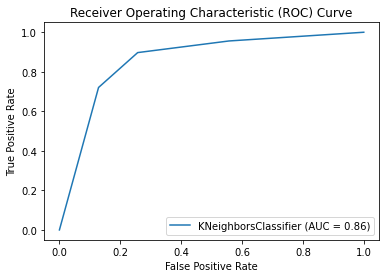




Cross-Validation Evaluation
Cross Validation Scores:  [0.83333333 0.81884058 0.88405797 0.85507246 0.89130435]
Average CV Score:  0.8565217391304347
Number of CV Scores used in Average:  5


In [41]:
# Model Evaluation (Pipeline Function)
master(knn=knn,X_test=X_test,y_test=y_test,scoresCV=scoresCV)

## ML Result Interpretation
### Classes: + , -
## Train-Test Split Evaluation:

#### For class '+', the precision is 0.88, indicating that 88% of the instances classified as '+' are actually positive.
#### For class '-', the precision is 0.77, indicating that 77% of the instances classified as '-' are actually negative.
#### For class '+', the recall is 0.74, indicating that 74% of the actual '+' instances were correctly identified by the classifier.
#### For class '-', the recall is 0.90, indicating that 90% of the actual '-' instances were correctly identified by the classifier.
#### For class '+', the F1-score is 0.81, representing the overall performance in terms of both precision and recall.
#### For class '-', the F1-score is 0.83, also representing the overall performance in terms of both precision and recall.
#### Accuracy measures the overall correctness of the classifier across all classes. The overall accuracy of the classifier is 0.82, or 82%.
#### AUC (Area Under the ROC Curve): 0.86 - The AUC score of 0.86 represents the model's ability to discriminate between positive and negative instances, with a higher value indicating better discrimination capability.

## Cross-Validation Evaluation:

#### Cross-Validation Scores: [0.8333, 0.8188, 0.8841, 0.8551, 0.8913]
#### Average CV Score: 0.8565
#### Number of CV Scores used in Average: 5


#### Comparing the average cross-validation score (0.8565) with the metrics from the train-test split evaluation, it appears that the average cross-validation score is slightly higher than the accuracy obtained from the train-test split (0.8188).

#### Therefore, based on these metrics, the Cross-Validation Evaluation shows slightly better results in terms of generalization performance. This suggests that the model's performance, as assessed through cross-validation, is slightly more reliable and indicative of its ability to generalize to unseen data compared to the single train-test split evaluation

## Dataset - 3
### Title: Mushroom Classification

#### Data Connection

In [42]:
# Dataset Fetching (Pipeline Function)
df,label_column=master()

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 1
Please enter the UCI ID 73
Successfuly Connected to the Data Source


In [43]:
# Missing Values are Present
df.iloc[:,1:].tail(20)

,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
8104,s,n,f,n,a,c,b,y,e,NaN,...,o,o,p,o,o,p,n,v,l,e
8105,s,n,f,n,a,c,b,y,e,NaN,...,o,o,p,n,o,p,y,v,l,e
8106,s,n,f,n,a,c,b,o,e,NaN,...,o,o,p,o,o,p,n,v,l,e
8107,s,n,f,n,a,c,b,y,e,NaN,...,o,o,p,o,o,p,n,c,l,e
8108,y,e,f,y,f,c,n,b,t,NaN,...,p,w,p,w,o,e,w,v,l,p
8109,s,w,f,n,f,w,b,w,e,NaN,...,w,w,p,w,t,p,w,n,g,e
8110,s,n,f,n,a,c,b,o,e,NaN,...,o,o,p,o,o,p,n,v,l,e
8111,s,w,f,n,f,w,b,p,e,NaN,...,w,w,p,w,t,p,w,n,g,e
8112,s,n,f,n,a,c,b,o,e,NaN,...,o,o,p,n,o,p,b,v,l,e
8113,y,e,f,y,f,c,n,b,t,NaN,...,p,p,p,w,o,e,w,v,d,p


In [44]:
# Manual Checking
# No Manual Data Type Correction and Removal of Redundant Column Required
print(df.info())

# No Manual label Correction Required
print("")
print(df[label_column].value_counts())

# No Manual Data Entry Error Correction Required
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,o,o,p,o,o,p,b,c,l,e
8120,x,s,n,f,n,a,c,b,y,e,...,o,o,p,n,o,p,b,v,l,e
8121,f,s,n,f,n,a,c,b,n,e,...,o,o,p,o,o,p,b,c,l,e
8122,k,y,n,f,y,f,c,n,b,t,...,w,w,p,w,o,e,w,v,l,p


In [45]:
# Missing Value Treatment (Pipeline Function)
master(df)
print(" ")
print(df.isna().sum())

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 2
Dataset is treated for missing values successfully
 
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number             

In [46]:
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


#### Exploratory Data Analysis

In [47]:
# No numerical features present in the data to generate summary and plots!

In [48]:
# Target Feature Class Balance (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 4


e   51.80
p   48.20
Name: poisonous, dtype: float64

In [49]:
# EDA Interpretation

#### Data Transformation

In [50]:
# Categorical Encoding (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 6


In [51]:
# Standardization of Numerical Features (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 7
1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


In [52]:
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,1.03,0.14,-0.20,1.19,0.88,0.16,-0.44,1.49,-0.23,-1.14,...,0.62,0.63,0.00,0.14,-0.26,0.95,-0.67,-0.51,2.03,p
1,1.03,0.14,1.77,1.19,-1.97,0.16,-0.44,-0.67,-0.23,-1.14,...,0.62,0.63,0.00,0.14,-0.26,0.95,-0.25,-1.31,-0.30,e
2,-2.09,0.14,1.37,1.19,-0.54,0.16,-0.44,-0.67,0.05,-1.14,...,0.62,0.63,0.00,0.14,-0.26,0.95,-0.25,-1.31,0.87,e
3,1.03,0.95,1.37,1.19,0.88,0.16,-0.44,1.49,0.05,-1.14,...,0.62,0.63,0.00,0.14,-0.26,0.95,-0.67,-0.51,2.03,p
4,1.03,0.14,-0.59,-0.84,0.41,0.16,2.28,-0.67,-0.23,0.87,...,0.62,0.63,0.00,0.14,-0.26,-1.27,-0.25,-2.91,-0.30,e


#### Outlier Detection & Treatment

In [53]:
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 8


'Outlier detection and treatment functionality under progress!'

#### Feature Selection & Dimensionality Reduction not to be done in this submission as per the instructions

#### Data Splitting and Cross-Validation

In [54]:
# Train-Test Split and CV Folds (Pipeline Function)
X_train,X_test,y_train,y_test,sk_folds=master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 9
Random State? 42
What % of data to be left for test? 20
How many folds required? 5


#### Model Selection

In [55]:
# Model Selection (Pipeline Function)
master(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 10


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  2.03it/s]

[LightGBM] [Info] Number of positive: 3134, number of negative: 3365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 6499, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482228 -> initscore=-0.071118
[LightGBM] [Info] Start training from score -0.071118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
AdaBoostClassifier                 1.00               1.00    None      1.00   
KNeighborsClassifier               1.00               1.

In [56]:
# For this submission, our model of choice is KNN:

# Model                            Accuracy  Balanced Accuracy  ROC AUC  F1 Score                                                                       
# KNeighborsClassifier               1.00               1.00    None      1.00 

#### Model Training

In [57]:
# Model Training (Pipeline Function)
knn,scoresCV=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train,sk_folds=sk_folds)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 11
What is the value of K? 3


#### Model Evaluation

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 12



Train-Test Split Evaluation
              precision  recall  f1-score  support
p                  1.00    1.00      1.00   843.00
e                  1.00    1.00      1.00   782.00
accuracy           1.00    1.00      1.00     1.00
macro avg          1.00    1.00      1.00  1625.00
weighted avg       1.00    1.00      1.00  1625.00


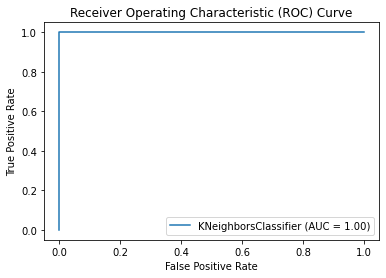




Cross-Validation Evaluation
Cross Validation Scores:  [1.         1.         1.         0.99938462 1.        ]
Average CV Score:  0.9998769230769231
Number of CV Scores used in Average:  5


In [58]:
# Model Evaluation (Pipeline Function)
master(knn=knn,X_test=X_test,y_test=y_test,scoresCV=scoresCV)

## ML Result Interpretation
### Classes: p , e
## Train-Test Split Evaluation:

#### For class 'p', the precision is 1.00, indicating that 100% of the instances classified as 'p' are actually 'p'.
#### For class 'e', the precision is 1.00, indicating that 100% of the instances classified as 'e' are actually 'e'.
#### For class 'p', the recall is 1.00, indicating that 100% of the actual 'p' instances were correctly identified by the classifier.
#### For class 'e', the recall is 1.00, indicating that 100% of the actual 'e' instances were correctly identified by the classifier.
#### For class 'p', the F1-score is 1.00, representing the overall performance in terms of both precision and recall.
#### For class 'e', the F1-score is 1.00, also representing the overall performance in terms of both precision and recall.
#### Accuracy measures the overall correctness of the classifier across all classes. The overall accuracy of the classifier is 1.00, or 100%.
#### AUC (Area Under the ROC Curve): 1.00 - The AUC score of 1.00 represents the model's ability to discriminate between positive and negative instances, with a higher value indicating better discrimination capability.


## Cross-Validation Evaluation:

#### Cross-Validation Scores: [1.0, 1.0, 1.0, 0.9994, 1.0]
#### Average CV Score: 0.9999
#### Number of CV Scores used in Average: 5
#### These metrics demonstrate exceptional performance across both evaluation methods. Specifically:

#### Perfect Scores in Train-Test Split Evaluation:

#### The model achieved perfect scores across all evaluation metrics (precision, recall, F1 score, accuracy, and AUC) in the train-test split evaluation. This indicates that the model correctly classified all instances in the test set with no errors.
#### High Scores in Cross-Validation Evaluation:

#### The cross-validation evaluation also yielded exceptionally high scores, with an average cross-validation score of 0.9999. This suggests that the model's performance is consistent across different folds of the dataset, further confirming its robustness and reliability.

#### In summary, both evaluation methods demonstrate that the model performs exceptionally well, with perfect or near-perfect scores across all metrics. However we see that one instance on CV deviates from the perfect score which helps is understanding the 100% in test dataset. It seems that there's data leakage when we're splitting the dataset and there are identical and near identifcal data samples present in the test set which means that data samples in training with particular feature values are present as it is in the test set thereby rendering 100% accuracy in the test data set. So even though by definition this doesn't seem overfitting (as test accuracy is 100% and not train) but due to limited data we are indeed overfitting as there's not enough variety of new data to test the model. We can increase the test size but that will reduce our model's learning so a bigger dataset with varying data samples is required. 

## Dataset - 4
### Title: Bank Marketing

#### Data Connection

In [59]:
# Dataset Fetching (Pipeline Function)
df,label_column=master()

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 1
Please enter the UCI ID 222
Successfuly Connected to the Data Source


In [60]:
# Missing Values are Present
df.head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no
5,35,management,married,tertiary,no,231,yes,no,NaN,5,may,139,1,-1,0,NaN,no
6,28,management,single,tertiary,no,447,yes,yes,NaN,5,may,217,1,-1,0,NaN,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,NaN,5,may,380,1,-1,0,NaN,no
8,58,retired,married,primary,no,121,yes,no,NaN,5,may,50,1,-1,0,NaN,no
9,43,technician,single,secondary,no,593,yes,no,NaN,5,may,55,1,-1,0,NaN,no


#### Data Cleaning

In [61]:
# Manual Checking
# No Manual Data Type Correction and Removal of Redundant Column Required
print(df.info())

# No Manual label Correction Required
print("")
print(df[label_column].unique())

# Manually drop column with more than 80% missing values
df.drop(['poutcome'],axis=1,inplace=True)

# No Manual Data Entry Error Correction Required
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None

['no' 'yes']


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,no


In [62]:
# Missing Value Treatment (Pipeline Function)
master(df)
print(" ")
print(df.isna().sum())

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 2
Dataset is treated for missing values successfully
 
age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
y              0
dtype: int64


In [63]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,no


#### Exploratory Data Analysis

In [64]:
# Numerical Features Summary (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 3


,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00,45211.00
mean,40.94,1362.27,15.81,258.16,2.76,40.20,0.58
std,10.62,3044.77,8.32,257.53,3.10,100.13,2.30
min,18.00,-8019.00,1.00,0.00,1.00,-1.00,0.00
25%,33.00,72.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,448.00,16.00,180.00,2.00,-1.00,0.00
75%,48.00,1428.00,21.00,319.00,3.00,-1.00,0.00
max,95.00,102127.00,31.00,4918.00,63.00,871.00,275.00


In [65]:
# Target Feature Class Balance (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 4


no    88.30
yes   11.70
Name: y, dtype: float64

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 5

Box and Distribution Plot - duration


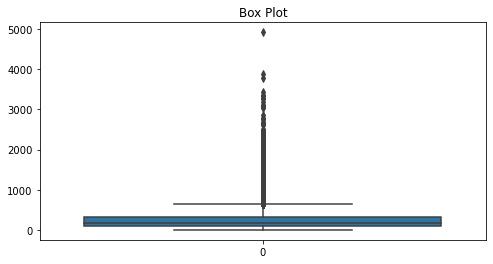

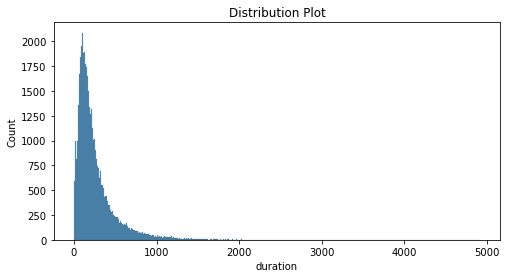

Skewness: 3.1442137770103913
Right Skewed 

Kurtosis: 18.151774935186822
Leptokurtic 

JB Test for Normality
695178.0017779735 0.0
Distribution is not normal 


Box and Distribution Plot - balance


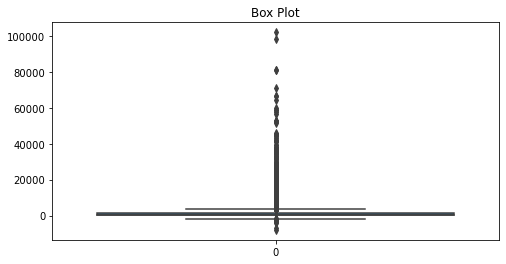

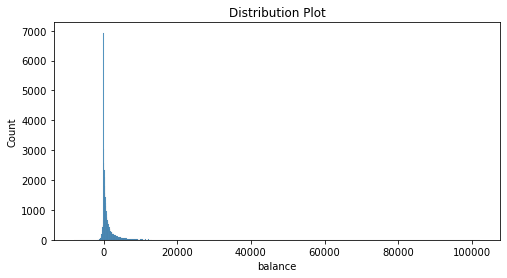

Skewness: 8.360030947252687
Right Skewed 

Kurtosis: 140.73584832577242
Leptokurtic 

JB Test for Normality
37838102.15611868 0.0
Distribution is not normal 


Box and Distribution Plot - age


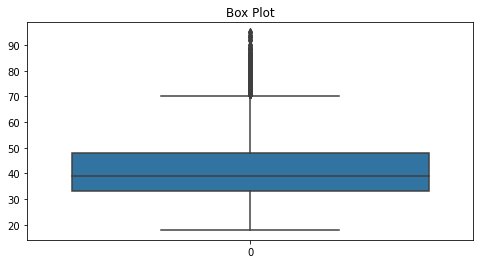

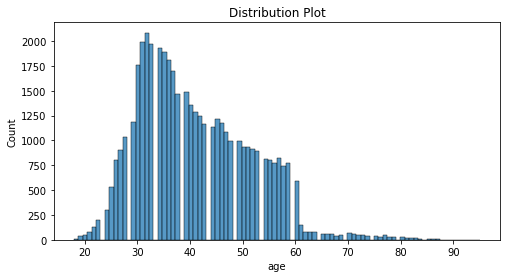

Skewness: 0.6847952047866451
Right Skewed 

Kurtosis: 0.31940232676995794
Platykurtic 

JB Test for Normality
3725.755126488409 0.0
Distribution is not normal 


Box and Distribution Plot - day_of_week


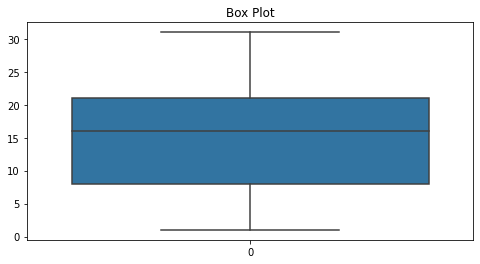

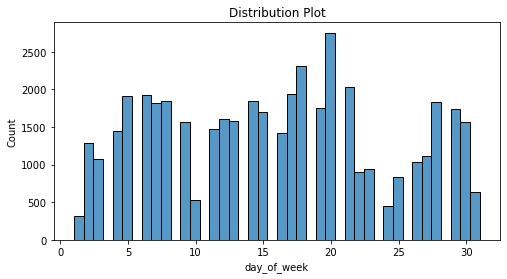

Skewness: 0.09307592583897241
Right Skewed 

Kurtosis: -1.0599128678304488
Platykurtic 

JB Test for Normality
2181.558469710561 0.0
Distribution is not normal 


Box and Distribution Plot - pdays


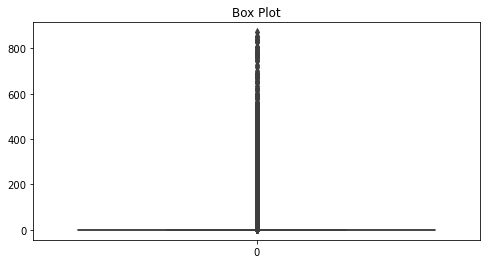

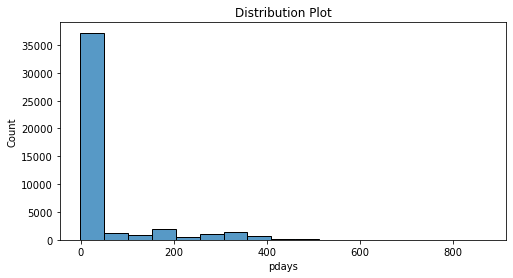

Skewness: 2.615628689259389
Right Skewed 

Kurtosis: 6.934295545084991
Leptokurtic 

JB Test for Normality
142133.0390956953 0.0
Distribution is not normal 



In [66]:
# Histograms and Boxplots of important numerical variables (Pipeline Function)
master(df)

## EDA Interpretation

## 1. Duration (last contact duration, in seconds (numeric))

####   According to box plot 50% of values lie between 103 to 319 the median line is towards to bottom box hence postively skewed

#### Right-skewness, with a substantial concentration of data towards lower values and a tail towards higher values.
#### Leptokurtosis, indicating heavier tails and a sharper peak compared to a normal distribution, suggestive of a significant number of extreme values.
#### A profound deviation from normality, as indicated by both the skewness, kurtosis values, and the Jarque-Bera test. This underscores a significant departure from the expected characteristics of a normal distribution, necessitating careful consideration in subsequent analyses or modeling.

## 2. Balance (average yearly balance)

#### According to box plot 50% of values lie between 72 to 1428 the median line is towards to bottom box hence postively skewed

#### Strong right-skewness, with a significant concentration of data towards lower values and a long tail extending towards higher values.
#### High leptokurtosis, indicating heavier tails and a sharper peak compared to a normal distribution, suggestive of a large number of extreme values.
#### A profound departure from normality, as evidenced by the extremely large skewness, kurtosis values, and JB test statistic. This highlights a significant deviation from the expected characteristics of a normal distribution, necessitating careful consideration in subsequent analyses or modeling.



## 3. Age

#### According to box plot 50% of values lie between 33 to 48 the median line is towards to bottom box hence postively skewed

#### Moderate right-skewness, with a moderate concentration of data towards lower values and a tail towards higher values.
#### Platykurtosis, indicating lighter tails and a flatter peak compared to a normal distribution.
#### A significant departure from normality, as indicated by both the skewness, kurtosis values, and JB test statistic. This suggests a deviation from the expected characteristics of a normal distribution and highlights the need for careful consideration in subsequent analyses or modeling.

## 4. day_of_week

#### According to box plot 50% of values lie between 8 to 21 the median line is towards to top box hence negatively skewed. which is opposite to histogram but from analysis it can be due to so much random distribution of values

#### Slight right-skewness, with a slight concentration of data towards lower values and a tail towards higher values.
#### Platykurtosis, indicating lighter tails and a flatter peak compared to a normal distribution.
#### A significant deviation from normality, as indicated by both the skewness, kurtosis values, and JB test statistic. This suggests a departure from the expected characteristics of a normal distribution and underscores the need for careful consideration in subsequent analyses or modeling.

## 5. p_days (number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted))

#### According to box plot 50% of values lie between -1 to -1 the median line is towards to bottom box hence postively skewed

#### Right-skewness, with a significant concentration of data towards lower values and a long tail towards higher values.
#### Leptokurtosis, indicating heavier tails and a sharper peak compared to a normal distribution, suggestive of a significant number of extreme values.
#### A substantial deviation from normality, as indicated by both the skewness, kurtosis values, and JB test statistic. This suggests a notable departure from the expected characteristics of a normal distribution, underscoring the need for careful consideration in subsequent analyses or modeling.

#### Data Transformation

In [67]:
# Categorical Encoding (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 6


In [68]:
# Standardization of Numerical Features (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 7
1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


In [69]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,y
0,1.61,-0.09,-0.28,1.31,-0.14,0.26,0.89,-0.44,-0.26,-1.30,0.82,0.01,-0.57,-0.41,-0.25,no
1,0.29,1.46,1.37,-0.22,-0.14,-0.44,0.89,-0.44,-0.26,-1.30,0.82,-0.42,-0.57,-0.41,-0.25,no
2,-0.75,-0.70,-0.28,-0.22,-0.14,-0.45,0.89,2.29,-0.26,-1.30,0.82,-0.71,-0.57,-0.41,-0.25,no
3,0.57,-1.01,-0.28,-0.22,-0.14,0.05,0.89,-0.44,-0.26,-1.30,0.82,-0.65,-0.57,-0.41,-0.25,no
4,-0.75,-1.01,1.37,-0.22,-0.14,-0.45,-1.12,-0.44,-0.26,-1.30,0.82,-0.23,-0.57,-0.41,-0.25,no


#### Outlier Detection & Treatment

In [70]:
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 8


'Outlier detection and treatment functionality under progress!'

#### Feature Selection & Dimensionality Reduction not to be done in this submission as per the instructions

#### Data Splitting and Cross-Validation

In [71]:
# Train-Test Split and CV Folds (Pipeline Function)
X_train,X_test,y_train,y_test,sk_folds=master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 9
Random State? 42
What % of data to be left for test? 20
How many folds required? 5


#### Model Selection

In [72]:
# Model Selection (Pipeline Function)
#master(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
# Due to limited RAM and data size, lazy classifier cannot be executed as it tests 29 different classifiers.

In [73]:
# For this submission, our model of choice is KNN regardless:

#### Model Training

In [74]:
# Model Training (Pipeline Function)
knn,scoresCV=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train,sk_folds=sk_folds)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 11
What is the value of K? 3


#### Model Evaluation

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 12



Train-Test Split Evaluation
              precision  recall  f1-score  support
no                 0.91    0.96      0.94  7952.00
yes                0.54    0.34      0.42  1091.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.73    0.65      0.68  9043.00
weighted avg       0.87    0.89      0.87  9043.00


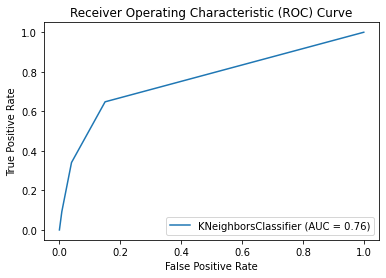




Cross-Validation Evaluation
Cross Validation Scores:  [0.88654208 0.88243751 0.88254811 0.88852024 0.88509179]
Average CV Score:  0.885027946426084
Number of CV Scores used in Average:  5


In [75]:
# Model Evaluation (Pipeline Function)
master(knn=knn,X_test=X_test,y_test=y_test,scoresCV=scoresCV)

## ML Result Interpretation
### Classes: no , yes
## Train-Test Split Evaluation:

#### For the class 'no', the precision is 0.91, indicating that 91% of the instances classified as 'no' are actually 'no'.
#### For the class 'yes', the precision is 0.54, indicating that 54% of the instances classified as 'yes' are actually 'yes'.
#### For the class 'no', the recall is 0.96, indicating that 96% of the actual 'no' instances were correctly identified by the classifier.
#### For the class 'yes', the recall is 0.34, indicating that 34% of the actual 'yes' instances were correctly identified by the classifier.
#### For the class 'no', the F1-score is 0.94, representing the overall performance in terms of both precision and recall.
#### For the class 'yes', the F1-score is 0.42, also representing the overall performance in terms of both precision and recall.
#### Accuracy measures the overall correctness of the classifier across all classes. The overall accuracy of the classifier is 0.89, or 89%.
#### AUC: 0.76 - The AUC score of 0.76 represents the model's ability to discriminate between positive and negative instances, with a higher value indicating better discrimination capability.


## Cross-Validation Evaluation:

#### Average CV Score: 0.8850
#### The average cross-validation score provides a robust estimate of the model's generalization performance, indicating that the model performs well on unseen data.
#### The individual cross-validation scores are also relatively high, ranging from approximately 0.8824 to 0.8885.
#### In summary, both evaluation methods suggest that the model performs reasonably well. The Train-Test Split Evaluation provides insights into the model's performance on a specific test set, while the Cross-Validation Evaluation offers a more robust estimate of its generalization performance. The model demonstrates good accuracy and predictive capability, although there is room for improvement in precision, recall, and AUC
#### While both methods show good results, the Cross-Validation Evaluation method provides a more robust estimate of the model's generalization performance and is therefore slightly preferable in this context

## Dataset - 5
### Title: Heart Disease

#### Data Connection

In [76]:
# Dataset Fetching (Pipeline Function)
df,label_column=master()

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 1
Please enter the UCI ID 45
Successfuly Connected to the Data Source


In [77]:
# Missing Values are Present
df.tail(20)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
283,35,1,2,122,192,0,0,174,0,0.00,1,0.00,3.00,0
284,61,1,4,148,203,0,0,161,0,0.00,1,1.00,7.00,2
285,58,1,4,114,318,0,1,140,0,4.40,3,3.00,6.00,4
286,58,0,4,170,225,1,2,146,1,2.80,2,2.00,6.00,2
287,58,1,2,125,220,0,0,144,0,0.40,2,nan,7.00,0
288,56,1,2,130,221,0,2,163,0,0.00,1,0.00,7.00,0
289,56,1,2,120,240,0,0,169,0,0.00,3,0.00,3.00,0
290,67,1,3,152,212,0,2,150,0,0.80,2,0.00,7.00,1
291,55,0,2,132,342,0,0,166,0,1.20,1,0.00,3.00,0
292,44,1,4,120,169,0,0,144,1,2.80,3,0.00,6.00,2


#### Data Cleaning

In [78]:
# Manual Checking
# No Manual Data Type Correction and Removal of Redundant Column Required
print(df.info())

# Manual label Correction Required
print("")
df[label_column] = df[label_column].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
print(df[label_column].unique())

# No Manual Data Entry Error Correction Required
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB
None

[0 1]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.30,3,0.00,6.00,0
1,67,1,4,160,286,0,2,108,1,1.50,2,3.00,3.00,1
2,67,1,4,120,229,0,2,129,1,2.60,2,2.00,7.00,1
3,37,1,3,130,250,0,0,187,0,3.50,3,0.00,3.00,0
4,41,0,2,130,204,0,2,172,0,1.40,1,0.00,3.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.20,2,0.00,7.00,1
299,68,1,4,144,193,1,0,141,0,3.40,2,2.00,7.00,1
300,57,1,4,130,131,0,0,115,1,1.20,2,1.00,7.00,1
301,57,0,2,130,236,0,2,174,0,0.00,2,1.00,3.00,1


In [79]:
# Missing Value Treatment (Pipeline Function)
master(df)
print(" ")
print(df.isna().sum())

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 2
Dataset is treated for missing values successfully
 
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [80]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.30,3,0.00,6.00,0
1,67,1,4,160,286,0,2,108,1,1.50,2,3.00,3.00,1
2,67,1,4,120,229,0,2,129,1,2.60,2,2.00,7.00,1
3,37,1,3,130,250,0,0,187,0,3.50,3,0.00,3.00,0
4,41,0,2,130,204,0,2,172,0,1.40,1,0.00,3.00,0


#### Exploratory Data Analysis

In [81]:
# Numerical Features Summary (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 3


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.44,0.68,3.16,131.69,246.69,0.15,0.99,149.61,0.33,1.04,1.60,0.66,4.73,0.46
std,9.04,0.47,0.96,17.60,51.78,0.36,0.99,22.88,0.47,1.16,0.62,0.93,1.93,0.50
min,29.00,0.00,1.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,3.00,0.00
25%,48.00,0.00,3.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,3.00,0.00
50%,56.00,1.00,3.00,130.00,241.00,0.00,1.00,153.00,0.00,0.80,2.00,0.00,3.00,0.00
75%,61.00,1.00,4.00,140.00,275.00,0.00,2.00,166.00,1.00,1.60,2.00,1.00,7.00,1.00
max,77.00,1.00,4.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,7.00,1.00


In [82]:
# Target Feature Class Balance (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 4


0   54.13
1   45.87
Name: num, dtype: float64

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 5

Box and Distribution Plot - cp


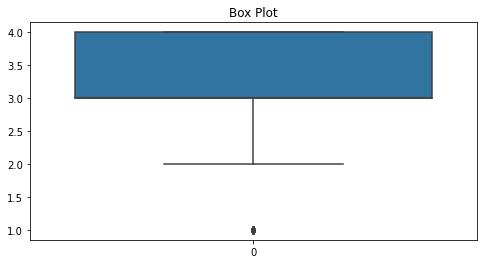

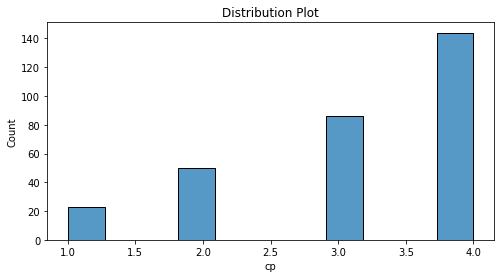

Skewness: -0.8375810336955507
Left Skewed 

Kurtosis: -0.41381067241945146
Platykurtic 

JB Test for Normality
37.589766211007635 6.878377090124843e-09
Distribution is not normal 


Box and Distribution Plot - thal


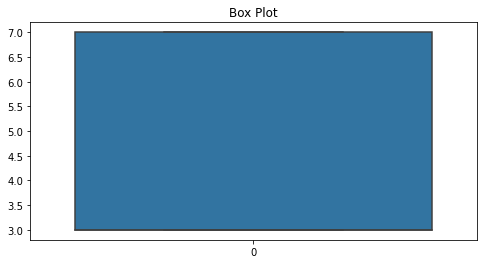

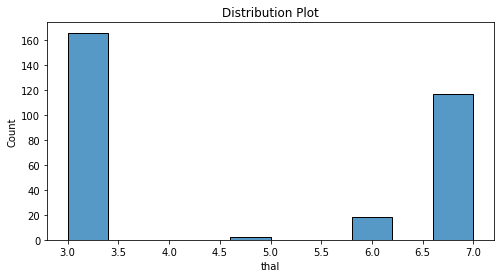

Skewness: 0.24403409291164038
Right Skewed 

Kurtosis: -1.8985636326793576
Platykurtic 

JB Test for Normality
48.514774569486526 2.918443264832149e-11
Distribution is not normal 


Box and Distribution Plot - ca


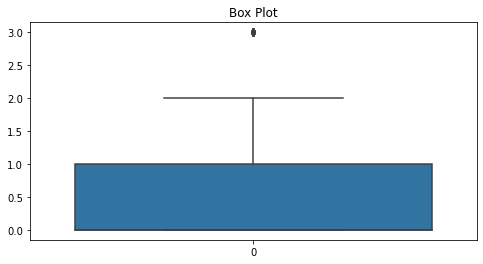

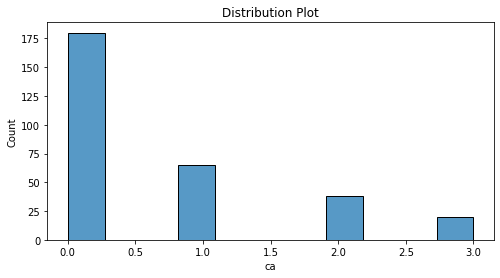

Skewness: 1.2027985414541353
Right Skewed 

Kurtosis: 0.282799716113598
Platykurtic 

JB Test for Normality
74.06927168472522 1.1102230246251565e-16
Distribution is not normal 


Box and Distribution Plot - oldpeak


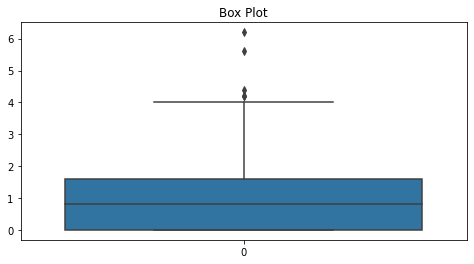

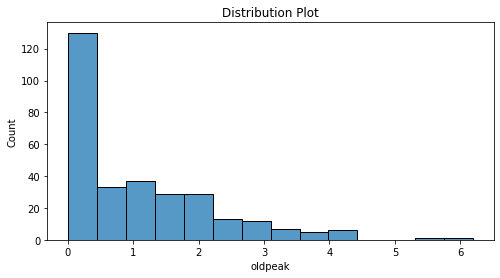

Skewness: 1.263425524589159
Right Skewed 

Kurtosis: 1.5301925815010025
Platykurtic 

JB Test for Normality
110.17162771033014 0.0
Distribution is not normal 


Box and Distribution Plot - thalach


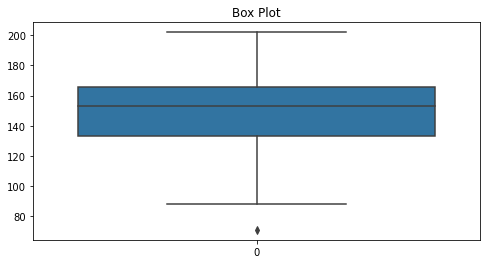

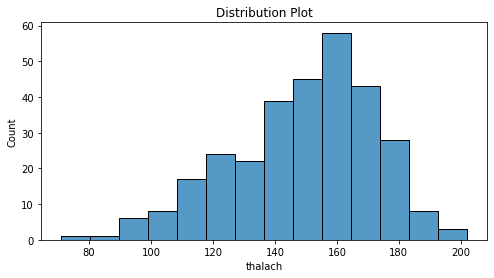

Skewness: -0.5347843657141508
Left Skewed 

Kurtosis: -0.0723983595428126
Platykurtic 

JB Test for Normality
14.508887270634663 0.0007070256339871683
Distribution is not normal 



In [83]:
# Histograms and Boxplots of important numerical variables (Pipeline Function)
master(df)

## Interpretation


## 1. thalach (maximum heart rate achieved)

####   According to box plot 50% of values lie between 133.5 to 166 the median line is closer to top box hence negatively skewed

####        The data distribution is left-skewed, indicating that it is asymmetric with a longer tail on the left side.
####    The distribution has lighter tails and is less peaked than a normal distribution, suggesting fewer extreme values.
####    The data does not follow a normal distribution, as indicated by both statistical tests and visual inspection of the histogram and box plot.
####    This implies that the assumptions of normality may not hold for this dataset
    
## 2. oldpeak (ST depression induced by exercise relative to rest)

####   According to box plot 50% of values lie between 0 to 1.6 the median line is slightly towards to bottom box hence slightly postively skewed

#### The data distribution is right-skewed, indicating that it is asymmetric with a longer tail on the right side.
#### The distribution has lighter tails and is less peaked than a normal distribution, suggesting fewer extreme values.
#### The data does not follow a normal distribution, as indicated by both statistical tests and visual inspection of the histogram and box plot. This implies that the assumptions of normality may not hold for this dataset.

## 3. thal (thal: 3 = normal; 6 = fixed defect; 7 = reversable defect based on heart rate)

####   According to box plot 50% of values lie between 3 to 7 the median line is towards to bottom box hence postively skewed

#### The data distribution is right-skewed, indicating that it is asymmetric with a longer tail on the right side.
#### The distribution has heavier tails and a sharper peak than a normal distribution, suggesting more extreme values and higher kurtosis.
#### The data does not follow a normal distribution, as indicated by both statistical tests and visual inspection of the histogram and box plot. This implies that the assumptions of normality may not hold for this dataset.


## 4. cp (chest pain type(0-4))

####   According to box plot 50% of values lie between 3 to 4 the median line is closer to top box hence negatively skewed

#### The data distribution is left-skewed, indicating that it is asymmetric with a longer tail on the left side.
#### The distribution has lighter tails and is less peaked than a normal distribution, suggesting fewer extreme values.
#### The data doesn't follow a normal distribution, as indicated by the Jarque-Bera test as well as indicated from platykurtic and negatively skewed distribution shape.


## 5. ca (number of major vessels (0-3) colored by flourosopy)

####   According to box plot 50% of values lie between 0 to 1 the median line is towards to bottom box hence postively skewed

#### The data distribution is right-skewed, indicating that it is asymmetric with a longer tail on the right side.
#### The distribution has lighter tails and is less peaked than a normal distribution, suggesting fewer extreme values.
#### The data does not follow a normal distribution, as indicated by both statistical tests and visual inspection of the histogram and box plot. This implies that the assumptions of normality may not hold for this dataset.

#### Data Transformation

In [84]:
# Categorical Encoding (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 6


In [85]:
# Standardization of Numerical Features (Pipeline Function)
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 7
1- Standard Scaler
2- Min-Max Scaler
Which type of Scaler? 1


In [86]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.95,0.69,-2.25,0.76,-0.26,2.39,1.02,0.02,-0.70,1.09,2.27,-0.71,0.66,0
1,1.39,0.69,0.88,1.61,0.76,-0.42,1.02,-1.82,1.44,0.40,0.65,2.50,-0.90,1
2,1.39,0.69,0.88,-0.67,-0.34,-0.42,1.02,-0.90,1.44,1.35,0.65,1.43,1.17,1
3,-1.93,0.69,-0.17,-0.10,0.06,-0.42,-1.00,1.64,-0.70,2.12,2.27,-0.71,-0.90,0
4,-1.49,-1.46,-1.21,-0.10,-0.83,-0.42,1.02,0.98,-0.70,0.31,-0.98,-0.71,-0.90,0


#### Outlier Detection & Treatment

In [87]:
master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 8


'Outlier detection and treatment functionality under progress!'

#### Feature Selection & Dimensionality Reduction not to be done in this submission as per the instructions

#### Data Splitting and Cross-Validation

In [88]:
# Train-Test Split and CV Folds (Pipeline Function)
X_train,X_test,y_train,y_test,sk_folds=master(df)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 9
Random State? 42
What % of data to be left for test? 20
How many folds required? 5


#### Model Selection

In [89]:
# Model Selection (Pipeline Function)
master(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 10


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 25.24it/s]

[LightGBM] [Info] Number of positive: 107, number of negative: 135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442149 -> initscore=-0.232446
[LightGBM] [Info] Start training from score -0.232446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [90]:
# For this submission, our model of choice is KNN:

# Model                            Accuracy  Balanced Accuracy  ROC AUC  F1 Score                                                                       
# KNeighborsClassifier               0.92               0.92     0.92      0.92 

#### Model Training

In [91]:
# Model Training (Pipeline Function)
knn,scoresCV=master(data=df,X_train=X_train, X_test=X_test, y_train=y_train,sk_folds=sk_folds)

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 11
What is the value of K? 3


#### Model Evaluation

1- Fetch Data
2- Missing Values Treatment
3- EDA: Numerical Summary
4- EDA: Class Balance(%)
5- EDA: Histogram & Box Plot of Important Numerical Features
6- Categorical Encoding
7- Standardization of Numerical Features
8- Outliers Detection & Treatment
9-  Data Splitting & Cross-Validation
10- Model Selection
11- Model Training(KNN)
12- Model Evaluation
13- More Functions to be Added
What do you want to do? 12



Train-Test Split Evaluation
              precision  recall  f1-score  support
0                  0.90    0.93      0.92    29.00
1                  0.94    0.91      0.92    32.00
accuracy           0.92    0.92      0.92     0.92
macro avg          0.92    0.92      0.92    61.00
weighted avg       0.92    0.92      0.92    61.00


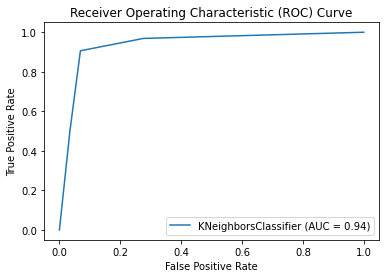




Cross-Validation Evaluation
Cross Validation Scores:  [0.86885246 0.78688525 0.83606557 0.85       0.8       ]
Average CV Score:  0.828360655737705
Number of CV Scores used in Average:  5


In [92]:
# Model Evaluation (Pipeline Function)
master(knn=knn,X_test=X_test,y_test=y_test,scoresCV=scoresCV)

## ML Result Interpretation

### Classes: 0 , 1
## Train-Test Split Evaluation:

#### For class '0', the precision is 0.90, indicating that 90% of the instances classified as '0' are actually '0'.
#### For class '1', the precision is 0.94, indicating that 94% of the instances classified as '1' are actually '1'.
#### For class '0', the recall is 0.93, indicating that 93% of the actual '0' instances were correctly identified by the classifier.
#### For class '1', the recall is 0.91, indicating that 91% of the actual '1' instances were correctly identified by the classifier.
#### For class '0', the F1-score is 0.92, representing the overall performance in terms of both precision and recall.
#### For class '1', the F1-score is 0.92, also representing the overall performance in terms of both precision and recall.
#### Accuracy measures the overall correctness of the classifier across all classes. The overall accuracy of the classifier is 0.92, or 92%.
#### AUC: 0.94 - The AUC score of 0.94 represents the model's ability to discriminate between positive and negative instances, with a higher value indicating better discrimination capability.


## Cross-Validation Evaluation:

#### Average CV Score: 0.8284
#### The average cross-validation score provides a robust estimate of the model's generalization performance, indicating that the model performs well on unseen data.
#### The individual cross-validation scores are also relatively high, ranging from approximately 0.8 to 0.8689.
#### In summary, both evaluation methods suggest that the model performs reasonably well. The Train-Test Split Evaluation provides insights into the model's performance on a specific test set, while the Cross-Validation Evaluation offers a more robust estimate of its generalization performance.
#### While both methods show good results, the Cross-Validation Evaluation method provides a more robust estimate of the model's generalization performance and is therefore slightly preferable in this context

## Compiled results are posted at the following github repo:
#### https://github.com/hase3b/KNN-Pipeline